In [1]:
import os
import operator

import pandas as pd
import numpy as np
import nltk

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
# from sklearn.utils import compute_class_weight, class_weight, resample

# from skimage import data, io, transform
# from skimage import img_as_ubyte

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model, clone_model

# Preprocessing

In [3]:
DF_PATH = 'goodreads-best-books/'
IMAGES_PATH = 'goodreads-best-books/images/images/'

In [4]:
books = pd.read_csv(DF_PATH + 'book_data.csv', encoding='utf8')
print(books.shape)
books.head()

(54301, 12)


,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
0,Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,9.78044E+12,374 pages,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.78044E+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.78006E+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,«È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.78068E+12,279 pages,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance,https://images.gr-assets.com/books/1320399351l...
4,Stephenie Meyer,About three things I was absolutely positive.F...,NaN,Paperback,9.78032E+12,498 pages,3.58,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...,https://images.gr-assets.com/books/1361039443l...


In [5]:
# Copy index as image name to maintain access to appropriate image file
books['img_name'] = books.index

In [6]:
# Drop extra columns
to_drop = ['book_desc', 'book_isbn', 'book_edition', 'book_format', 'book_pages', 'book_rating_count', 'book_review_count', 'book_rating']
books.drop(to_drop, inplace=True, axis=1)

# Move book_title column to after book_author
headers = books.columns.tolist()
headers = ['book_authors', 'book_title', 'image_url', 'img_name', 'genres']
books = books[headers]

# Remove extra author names
books['book_authors'] = books['book_authors'].str.split('|').str[0]

# Split label into list of genres
books['genres'] = books['genres'].str.split('|')

# Remove empty genres and book_desc
books = books[books['genres'].notna()]

books['genres'] = books['genres'].apply(lambda row: [genre for genre in row if genre in ['Fiction', 'Nonfiction']])
books.drop(books[books.genres.map(len) < 1].index, inplace=True)
books['genres'] = books['genres'].apply(lambda row: row[0])

# Remove rows with images with errors
books = books[-books['img_name'].isin(['2833', '17637', '33060', '44763', '49439'])]

# Remove rows with missing images
books = books[books['image_url'].notnull()].reset_index(drop = True)
books.drop(['image_url'], inplace=True, axis=1)

books.shape

(33520, 4)

In [7]:
books['genres']

0           Fiction
1           Fiction
2           Fiction
3           Fiction
4           Fiction
            ...    
33515       Fiction
33516    Nonfiction
33517    Nonfiction
33518    Nonfiction
33519    Nonfiction
Name: genres, Length: 33520, dtype: object

In [8]:
# Ensure image files and dataframe are synced
file_names = list(books['img_name'].apply(lambda row: str(row) + '.jpg'))
print("Matching image names: {}".format(len(set(file_names).intersection(list(os.listdir(IMAGES_PATH))))))

Matching image names: 33520


### Label Distribution

In [9]:
genres = [item for item in list(books.genres)]
all_genres = nltk.FreqDist(genres)
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 'Count': list(all_genres.values())})

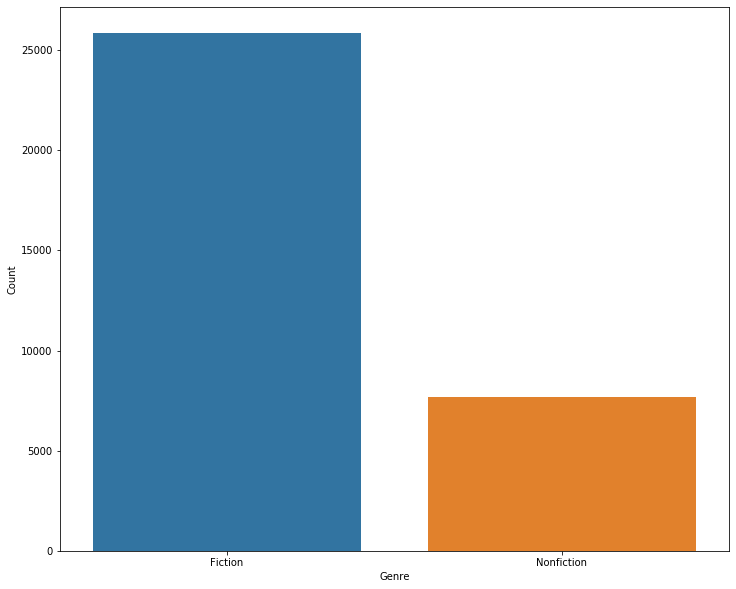

In [10]:
g = all_genres_df.nlargest(columns="Count", n = 2)
plt.figure(figsize=(12,10))
ax = sns.barplot(data=g, x="Genre", y="Count")
plt.show()

### Downsample for even distribution

In [11]:
fiction_books = books[books['genres']=='Fiction'].sample(n=all_genres['Nonfiction'], random_state=1)
nonfiction_books = books[books['genres']=='Nonfiction']

In [12]:
downsample = pd.concat([fiction_books, nonfiction_books])

## Features and labels

In [13]:
# Store resized images as arrays (Height, Width, Channels) to be our features
X = []

height = 100
width = 60
channels = 3

for i in tqdm(list(downsample['img_name'])):
    path = IMAGES_PATH + str(i) + '.jpg'
    img = image.load_img(path, target_size=(height, width, channels))
    img = image.img_to_array(img)
    img = img/255.0
    X.append(img)

100%|██████████| 15332/15332 [01:00<00:00, 251.70it/s]


In [14]:
X = np.array(X)

In [15]:
y = downsample['genres']

encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [16]:
rng_state = np.random.get_state()
np.random.shuffle(X)
np.random.set_state(rng_state)
np.random.shuffle(y)

In [17]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13, test_size = 0.15)

In [18]:
# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 13, test_size = 0.20)

### Augmentation

In [40]:
datagen = image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    featurewise_center=True,
    featurewise_std_normalization=True,
    shear_range=0.2,
)

<Figure size 432x288 with 0 Axes>

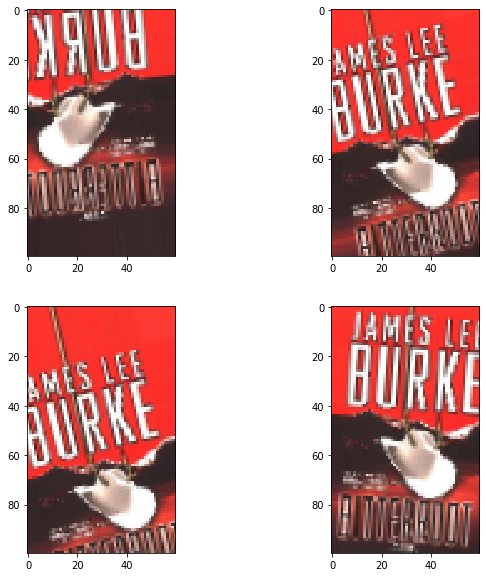

In [41]:
# visualize data augmentations
plt.clf()

img = X[14]
img = img.reshape((1,) + img.shape)
plt.figure(figsize=(10,10))

i = 0
for batch in datagen.flow(img, batch_size=1):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

In [42]:
# datagen.fit(X_train)

train_generator = datagen.flow(
    X_train,
    y_train,
    batch_size=32)


# do not augment validation data
test_datagen = image.ImageDataGenerator()

validation_generator = test_datagen.flow(
    X_val,
    y_val,
    batch_size=32)

### CNN

In [43]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, channels)))
model2.add(MaxPool2D((2, 2)))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPool2D((2, 2)))

model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPool2D((2, 2)))

model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy',
             optimizer=Adam(),
             metrics=['acc'])

In [44]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 98, 58, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 49, 29, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 49, 29, 32)        128       
_________________________________________________________________
dropout_4 (Dropout)          (None, 49, 29, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 47, 27, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 13, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 11, 128)      

In [45]:
history2 = model2.fit(
    train_generator,
    steps_per_epoch=int(len(X_train)/32),
    epochs= 125,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 325 steps, validate for 50 steps
Epoch 1/125
  1/325 [..............................] - ETA: 3:32 - loss: 0.9427 - acc: 0.4375

/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


325/325 [==============================] - 43s 132ms/step - loss: 0.7341 - acc: 0.5344 - val_loss: 0.6885 - val_acc: 0.5537
Epoch 2/125
325/325 [==============================] - 42s 129ms/step - loss: 0.6982 - acc: 0.5312 - val_loss: 0.7137 - val_acc: 0.5100
Epoch 3/125
325/325 [==============================] - 42s 129ms/step - loss: 0.6942 - acc: 0.5360 - val_loss: 0.6899 - val_acc: 0.5325
Epoch 4/125
325/325 [==============================] - 42s 129ms/step - loss: 0.6909 - acc: 0.5446 - val_loss: 0.6923 - val_acc: 0.5506
Epoch 5/125
325/325 [==============================] - 42s 129ms/step - loss: 0.6895 - acc: 0.5509 - val_loss: 0.6870 - val_acc: 0.5419
Epoch 6/125
325/325 [==============================] - 42s 129ms/step - loss: 0.6878 - acc: 0.5535 - val_loss: 0.6957 - val_acc: 0.5487
Epoch 7/125
325/325 [==============================] - 42s 129ms/step - loss: 0.6834 - acc: 0.5654 - val_loss: 0.6792 - val_acc: 0.5650
Epoch 8/125
325/325 [==============================] - 42s 1

Epoch 61/125
325/325 [==============================] - 42s 129ms/step - loss: 0.6408 - acc: 0.6296 - val_loss: 0.6455 - val_acc: 0.6194
Epoch 62/125
325/325 [==============================] - 42s 129ms/step - loss: 0.6404 - acc: 0.6288 - val_loss: 0.6892 - val_acc: 0.6069
Epoch 63/125
325/325 [==============================] - 42s 129ms/step - loss: 0.6389 - acc: 0.6305 - val_loss: 0.6474 - val_acc: 0.6275
Epoch 64/125
325/325 [==============================] - 41s 127ms/step - loss: 0.6355 - acc: 0.6383 - val_loss: 0.6307 - val_acc: 0.6400
Epoch 65/125
325/325 [==============================] - 41s 128ms/step - loss: 0.6428 - acc: 0.6263 - val_loss: 0.6559 - val_acc: 0.6187
Epoch 66/125
325/325 [==============================] - 42s 128ms/step - loss: 0.6380 - acc: 0.6338 - val_loss: 0.6463 - val_acc: 0.6394
Epoch 67/125
325/325 [==============================] - 41s 127ms/step - loss: 0.6337 - acc: 0.6372 - val_loss: 0.6545 - val_acc: 0.6356
Epoch 68/125
325/325 [===================

325/325 [==============================] - 41s 127ms/step - loss: 0.6114 - acc: 0.6607 - val_loss: 0.6302 - val_acc: 0.6481
Epoch 121/125
325/325 [==============================] - 41s 127ms/step - loss: 0.6044 - acc: 0.6675 - val_loss: 0.6959 - val_acc: 0.6494
Epoch 122/125
325/325 [==============================] - 41s 127ms/step - loss: 0.6016 - acc: 0.6709 - val_loss: 0.6572 - val_acc: 0.6525
Epoch 123/125
325/325 [==============================] - 41s 127ms/step - loss: 0.6026 - acc: 0.6721 - val_loss: 0.6923 - val_acc: 0.6363
Epoch 124/125
325/325 [==============================] - 41s 127ms/step - loss: 0.6064 - acc: 0.6627 - val_loss: 0.7186 - val_acc: 0.6225
Epoch 125/125
325/325 [==============================] - 41s 127ms/step - loss: 0.6002 - acc: 0.6691 - val_loss: 0.6440 - val_acc: 0.6400


### Training

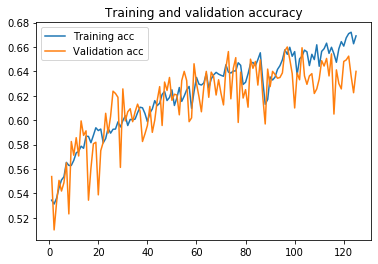

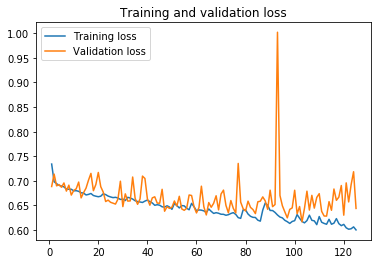

In [46]:
# plot error curves
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [47]:
score = model2.evaluate(X_test, y_test, verbose=1)
print('The augmentation accuracy is: ', score[1])

2300/2300 [==============================] - 2s 1ms/sample - loss: 0.6711 - acc: 0.6296
The augmentation accuracy is:  0.62956524


In [48]:
aug_predictions = model2.predict_classes(X_test)

print (classification_report(y_test, aug_predictions))
print('f1 score: ', f1_score(y_test, aug_predictions))

              precision    recall  f1-score   support

           0       0.64      0.59      0.61      1153
           1       0.62      0.67      0.64      1147

    accuracy                           0.63      2300
   macro avg       0.63      0.63      0.63      2300
weighted avg       0.63      0.63      0.63      2300

f1 score:  0.6447039199332777
